# ASTR 598 Astrostatistics
## HW2 Part 2
## Hayden Smotherman, Chris Suberlack, Winnie Wang
## To run this Notebook:

Data files have not been uploaded to github because of size. Group 2 is analyzing NSC data, which should all be in group2/HW_2/. The NSC files are generated by uploading the HW2_DL_NCS.ipynb notebook to datalab servers, running the notebook, then downloading the two .csv files that are output.

In [8]:
# Imports 
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
from astropy.io import fits
import pandas as pd
from scipy.stats import binned_statistic_2d as bs2d 


In [2]:
# Load the NSC data ...
# Group two is only using NSC data
table_neg = Table.read('NSC_stripe82_Dec_negative.csv')
table_pos = Table.read('NSC_stripe82_Dec_positive.csv')

# Stack the two tables vertically 
# ( rows over rows,  since the columns ARE IDENTICAL )
# this is even faster than any other merge, etc. 
nsc = vstack([table_neg, table_pos])

## Part (a)

     pmra     
--------------
 20.7896450186
-36.5220292315
 67.0208442867
 15.6868604322
 15.6081091423
 8.43755185746
-8.11144869815
-6.33511569495
 16.9516353813
-14.1119484285
           ...
 15.4168853475
-67.6105859086
 127.273208932
 108.533164203
 17.3310508464
 2.21740792915
 75.2407880106
-1.98087724115
-146.024863899
 -1809.1474918
-26.2884096076
Length = 7409326 rows


/home/hayden/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/hayden/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


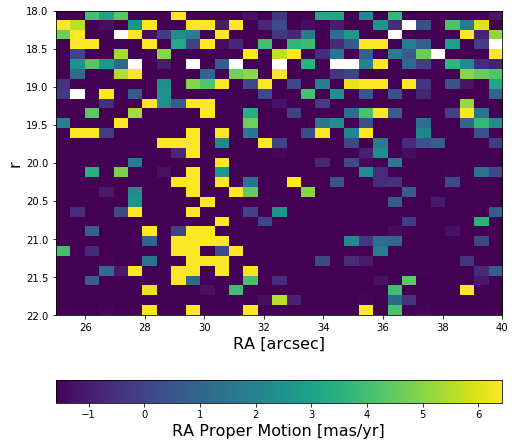

In [74]:
# Generate the magnitude mask used in the Hess diagram data analysis
def Hess_r_v_gminusi(nsc,total_mask):
    constant = 3
    nObjects = np.sum(total_mask)
    num_bins = int(constant * nObjects ** (1.0 / 4.0))

    # Now calculate the binned proper motions
    proper_motion = np.sqrt(nsc['pmra']**2+nsc['pmdec']**2)
    Binned_PM = bs2d(nsc['ra'][total_mask],nsc['rmag'][total_mask],nsc['pmra'][total_mask], bins = num_bins)


    cmin = min(np.log10(Binned_PM.statistic.T[Binned_PM.statistic.T >  0]))+ 0.1
    cmax = max(np.log10(Binned_PM.statistic.T[Binned_PM.statistic.T >  0]))- 0.1

    # Define custom colormaps: Set pixels with no sources to white
    cmap = plt.cm.viridis
    cmap.set_bad('w', 1.)

    plt.figure(figsize=[8,8])
    plt.imshow(Binned_PM.statistic.T, origin='lower',
                   extent=[Binned_PM.x_edge[0], Binned_PM.x_edge[-1], Binned_PM.y_edge[0], Binned_PM.y_edge[-1]],
                   aspect='auto', interpolation='nearest', cmap=cmap)

    cb = plt.colorbar(orientation='horizontal')
    cb.set_label(r'RA Proper Motion [mas/yr]',fontsize=16)
    plt.clim(cmin, cmax)

    plt.xlabel(r'RA [arcsec]',fontsize=16)
    plt.ylabel(r'r',fontsize=16)
    plt.gca().invert_yaxis()
    #plt.gca().invert_xaxis()

r_mask = (nsc['rmag']>18) & (nsc['rmag']<22)
gminusi_mask = ((nsc['gmag']-nsc['imag']) > 0.3) & ((nsc['gmag']-nsc['imag']) < 0.4)
mag_mask = r_mask * gminusi_mask

RA_mask = (nsc['ra'] > 25) & (nsc['ra'] < 40)
total_mask = mag_mask * RA_mask
Hess_r_v_gminusi(nsc,total_mask)

In [4]:
np.ravel(nsc)

array([ ( 315.00773225,  0.01269343,    20.78964502,    56.63178017,    49.04871799,    56.692844  ,  57505.16937473,  1097.99  ,  99.99  ,   9.99999000e+05,  9.99    ,  22.6357,   9.93700000e-03,  0.077408,  99.99  ,   9.99999000e+05,  9.99    ,  0.513441,  1.84063,  0.075699,  8),
       ( 315.01317257,  0.01268115,   -36.52202923,    50.85056192,   -50.76275273,    50.85669863,  57433.60177155,  1097.99  ,  99.99  ,   9.99999000e+05,  9.99    ,  22.7838,   3.38958000e-01,  0.072123,  21.7176,   0.00000000e+00,  0.097203,  0.629567,  1.65263,  0.075384,  8),
       ( 315.00806395,  0.0157378 ,    67.02084429,    38.07120104,    83.38997058,    38.10726438,  57335.72996715,  1097.99  ,  22.2732,   0.00000000e+00,  0.10526 ,  21.5492,   8.43930000e-02,  0.048594,  21.7195,   0.00000000e+00,  0.117781,  0.450854,  2.1217 ,  0.075477, 14),
       ...,
       (  44.99452377, -0.00611874,  -146.0248639 ,    91.12008849,   -54.35961251,    91.27157748,  56702.67308449,   595.203 ,  22.5598,

## Part (b)

## Part (c)